# Introduction
Based on P2P dataset of loan data. We will clean up the data, perform some basic analysis and model the data

### Imports
Import libraries and write settings here.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2
#date
import datetime

#
import itertools


# Visualizations
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import seaborn as sns

# machine learning
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score

# import plotly.plotly as py
# import plotly.graph_objs as go
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode(connected=True)

# import cufflinks as cf
# cf.go_offline(connected=True)
# cf.set_config_file(theme='white')

In [2]:
df= pd.read_csv("loan.csv", low_memory=False)

# PreProcessing


In [3]:
df = df[["funded_amnt", "term", "int_rate", "installment", "grade", "application_type", "sub_grade", "emp_length", "home_ownership",
         "annual_inc", "verification_status", "issue_d", "loan_status", "purpose", "addr_state", "dti", "open_acc", "tot_cur_bal", "all_util", "num_sats", "mort_acc", 
         "pct_tl_nvr_dlq", "total_acc", "last_pymnt_d"]].copy()

In [4]:
# Drop all current loans and joint loans
current_status = ["Current", "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]
df = df.loc[(df["application_type"] != "Joint App") & (~df["loan_status"].isin(current_status))].copy()

# Reduce loan_status values to "good" or "bad"
bad_status = ["Charged Off", "Does not meet the credit policy. Status:Charged Off", "Default"]
df["loan_status"] = df["loan_status"].apply(lambda x : "Bad" if x in bad_status else "Good")

# Encode the loan status to 0 or 1 
df['loan_status_n'] = df['loan_status'].map({'Bad':0,'Good':1})


# Convert emp_length to int
employment_length_to_int = {
                            'NaN' : 0,
                            '< 1 year' : 0,
                            '1 year' : 1,
                            '2 years' : 2,
                            '3 years' : 3,
                            '4 years' : 4,
                            '5 years' : 5,
                            '6 years' : 6,
                            '7 years' : 7,
                            '8 years' : 8,
                            '9 years' : 9,
                            '10+ years' : 10
                            }
df["emp_length"] = df["emp_length"].fillna('NaN').apply(lambda x : employment_length_to_int[x])
df['issue_d'] = pd.to_datetime(df['issue_d'])

In [5]:
data = df.copy()

In [6]:
data.describe()

,funded_amnt,int_rate,installment,emp_length,annual_inc,dti,open_acc,tot_cur_bal,all_util,num_sats,mort_acc,pct_tl_nvr_dlq,total_acc,loan_status_n
count,1.283143e+06,1.283143e+06,1.283143e+06,1.283143e+06,1.283139e+06,1.283143e+06,1.283114e+06,1.212867e+06,476565.000000,1.224553e+06,1.233113e+06,1.212713e+06,1.283114e+06,1.283143e+06
mean,1.431225e+04,1.323331e+01,4.354412e+02,5.646992e+00,7.648202e+04,1.800362e+01,1.159645e+01,1.403493e+05,58.189072,1.164978e+01,1.672651e+00,9.416867e+01,2.503765e+01,7.999358e-01
std,8.639600e+03,4.734387e+00,2.594479e+02,3.832226e+00,7.043168e+04,8.359684e+00,5.466381e+00,1.570707e+05,20.912622,5.474812e+00,2.007355e+00,8.725253e+00,1.200472e+01,4.000483e-01
min,5.000000e+02,5.310000e+00,4.930000e+00,0.000000e+00,1.896000e+03,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,7.800000e+03,9.750000e+00,2.475000e+02,2.000000e+00,4.600000e+04,1.174000e+01,8.000000e+00,2.931500e+04,44.000000,8.000000e+00,0.000000e+00,9.130000e+01,1.600000e+01,1.000000e+00
50%,1.200000e+04,1.274000e+01,3.732200e+02,6.000000e+00,6.500000e+04,1.752000e+01,1.100000e+01,7.927400e+04,59.000000,1.100000e+01,1.000000e+00,9.790000e+01,2.300000e+01,1.000000e+00
75%,2.000000e+04,1.599000e+01,5.762900e+02,1.000000e+01,9.000000e+04,2.388000e+01,1.400000e+01,2.093515e+05,73.000000,1.400000e+01,3.000000e+00,1.000000e+02,3.200000e+01,1.000000e+00
max,4.000000e+04,3.099000e+01,1.719830e+03,1.000000e+01,1.099920e+07,4.996000e+01,9.000000e+01,8.000078e+06,198.000000,9.000000e+01,5.100000e+01,1.000000e+02,1.760000e+02,1.000000e+00


## Subgrade encoding

In [7]:
#required

lst = [data]
data['sub_int'] = np.nan

for col in lst:
    col.loc[col['sub_grade']=='A1', 'sub_int'] = 1
    col.loc[col['sub_grade']=='A2', 'sub_int'] = 2
    col.loc[col['sub_grade']=='A3', 'sub_int'] = 3
    col.loc[col['sub_grade']=='A4', 'sub_int'] = 4
    col.loc[col['sub_grade']=='A5', 'sub_int'] = 5
    col.loc[col['sub_grade']=='B1', 'sub_int'] = 6
    col.loc[col['sub_grade']=='B2', 'sub_int'] = 7
    col.loc[col['sub_grade']=='B3', 'sub_int'] = 8
    col.loc[col['sub_grade']=='B4', 'sub_int'] = 9
    col.loc[col['sub_grade']=='B5', 'sub_int'] = 10
    col.loc[col['sub_grade']=='C1', 'sub_int'] = 11
    col.loc[col['sub_grade']=='C2', 'sub_int'] = 12
    col.loc[col['sub_grade']=='C3', 'sub_int'] = 13
    col.loc[col['sub_grade']=='C4', 'sub_int'] = 14
    col.loc[col['sub_grade']=='C5', 'sub_int'] = 15
    col.loc[col['sub_grade']=='D1', 'sub_int'] = 16
    col.loc[col['sub_grade']=='D2', 'sub_int'] = 17
    col.loc[col['sub_grade']=='D3', 'sub_int'] = 18
    col.loc[col['sub_grade']=='D4', 'sub_int'] = 19
    col.loc[col['sub_grade']=='D5', 'sub_int'] = 20
    col.loc[col['sub_grade']=='E1', 'sub_int'] = 21
    col.loc[col['sub_grade']=='E2', 'sub_int'] = 22
    col.loc[col['sub_grade']=='E3', 'sub_int'] = 23
    col.loc[col['sub_grade']=='E4', 'sub_int'] = 24
    col.loc[col['sub_grade']=='E5', 'sub_int'] = 25
    col.loc[col['sub_grade']=='F1', 'sub_int'] = 26
    col.loc[col['sub_grade']=='F2', 'sub_int'] = 27
    col.loc[col['sub_grade']=='F3', 'sub_int'] = 28
    col.loc[col['sub_grade']=='F4', 'sub_int'] = 29
    col.loc[col['sub_grade']=='F5', 'sub_int'] = 30
    col.loc[col['sub_grade']=='G1', 'sub_int'] = 30
    col.loc[col['sub_grade']=='G2', 'sub_int'] = 31
    col.loc[col['sub_grade']=='G3', 'sub_int'] = 32
    col.loc[col['sub_grade']=='G4', 'sub_int'] = 33
    col.loc[col['sub_grade']=='G5', 'sub_int'] = 35 

In [8]:
data.columns

Index(['funded_amnt', 'term', 'int_rate', 'installment', 'grade',
       'application_type', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'addr_state', 'dti', 'open_acc', 'tot_cur_bal', 'all_util',
       'num_sats', 'mort_acc', 'pct_tl_nvr_dlq', 'total_acc', 'last_pymnt_d',
       'loan_status_n', 'sub_int'],
      dtype='object')

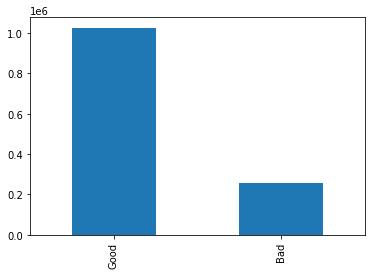

In [9]:
loans = data['loan_status'].value_counts().plot(kind='bar')



In [10]:
initial_loan_status_df = pd.DataFrame({
    "Counts" : data["loan_status"].value_counts(),
    "Percentages" : data["loan_status"].value_counts(normalize = True)
})

initial_loan_status_df["Counts"] = initial_loan_status_df["Counts"].map("{:,.0f}".format)
initial_loan_status_df["Percentages"] = initial_loan_status_df["Percentages"].map("{0:.2f}%".format)

initial_loan_status_df

,Counts,Percentages
Good,"1,026,432",0.80%
Bad,"256,711",0.20%


# Data Imbalance Mitigation

In [11]:
good_sample = data[(data.loan_status == "Good")]
bad_sample = data[(data.loan_status == "Bad")]
bad_adjusted = bad_sample.append([bad_sample] *3)
combined_sample = good_sample.append(bad_adjusted)

In [12]:
adjusted_loan_status_df = pd.DataFrame({
    "Counts" : combined_sample["loan_status"].value_counts(),
    "Percentages" : combined_sample["loan_status"].value_counts(normalize = True)
})

adjusted_loan_status_df["Counts"] = adjusted_loan_status_df["Counts"].map("{:,.0f}".format)
adjusted_loan_status_df["Percentages"] = adjusted_loan_status_df["Percentages"].map("{0:.2f}%".format)

adjusted_loan_status_df

,Counts,Percentages
Bad,"1,026,844",0.50%
Good,"1,026,432",0.50%


# Hot encoding the subgrades

In [13]:
cat_var = ['sub_grade']
data = pd.get_dummies(data, columns=cat_var)

In [14]:
data.columns

Index(['funded_amnt', 'term', 'int_rate', 'installment', 'grade',
       'application_type', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose',
       'addr_state', 'dti', 'open_acc', 'tot_cur_bal', 'all_util', 'num_sats',
       'mort_acc', 'pct_tl_nvr_dlq', 'total_acc', 'last_pymnt_d',
       'loan_status_n', 'sub_int', 'sub_grade_A1', 'sub_grade_A2',
       'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
       'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
       'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
       'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
       'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
       'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
       'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
       'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4',
       'sub_gr

In [15]:
combined_sample = pd.get_dummies(combined_sample, columns=cat_var)


In [16]:
combined_sample.columns

Index(['funded_amnt', 'term', 'int_rate', 'installment', 'grade',
       'application_type', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose',
       'addr_state', 'dti', 'open_acc', 'tot_cur_bal', 'all_util', 'num_sats',
       'mort_acc', 'pct_tl_nvr_dlq', 'total_acc', 'last_pymnt_d',
       'loan_status_n', 'sub_int', 'sub_grade_A1', 'sub_grade_A2',
       'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
       'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
       'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
       'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
       'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
       'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
       'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
       'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4',
       'sub_gr

# Functions

In [17]:
#Evaluation of Model - Confusion Matrix Plot
def plot_confusion_matrix(cm, title,
                          normalize=False,
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(5.5,4))
    xticks = ['Bad Loans', 'Good Loans']
    yticks = ['Bad Loans', 'Good Loans']
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cnf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cnf_matrix.flatten()/np.sum(cnf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    categories = ['Bad Loan','Positive']
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Reds', xticklabels=xticks, yticklabels=yticks)
    plt.xlabel('Predicated Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()
    

In [18]:
def get_confusion_stats(y_test, y_pred):
    """
    Based on y_test, and y_pred it will calculate a series of metrics
    true_positives (GOOD LOAN/GOODLOAN)
    false_positives(BAD LOAN/GOOD LOAN)
    true_negatives (BAD/BAD)
    false_negatives (GOOD/BAD)

    Accuracy - Classification Accuracy: Overall, how often is the classifier correct?

    Precision - This measure is important. We want close to 1.00.
    We cacluate the ratio of true positive over the entire sets of true positive and false positives

    Recall (aka sensitivity)-  We calculate the ratio of true positives over the entire sets of true positives and false negatives

    F1 Score-  ranges from 0 to 1. F1 Score reaches its best value at 1 (perfect precision & recall) and worst at 0,

    Specificity - True Negative Rate (Prportion of actual negaties that are correctly identified)

    """

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    total = tn+fp+fn+tp
    print("True Negatives: ", tn, (tn/total)*100)
    print("False Positives: ", fp, (fp/total)*100)
    print("False Negatives: ", fn, (fn/total)*100)
    print("True Positives: ", tp, (tp/total)*100)

    Accuracy = (tn+tp)*100/(tp+tn+fp+fn)
    print(f"Accuracy {Accuracy}")

    Precision = tp/(tp+fp)
    print("Precision {:0.2f}".format(Precision))

    Recall = tp/(tp+fn)
    print("Recall {:0.2f}".format(Recall))

    f1 = (2*Precision*Recall)/(Precision + Recall)
    print("F1 Score {:0.2f}".format(f1))

    Specificity = tn/(tn+fp)
    print("Specificity {:0.2f}".format(Specificity))

# Analysis/Modeling
Logistic Model

<Figure size 1080x1080 with 0 Axes>

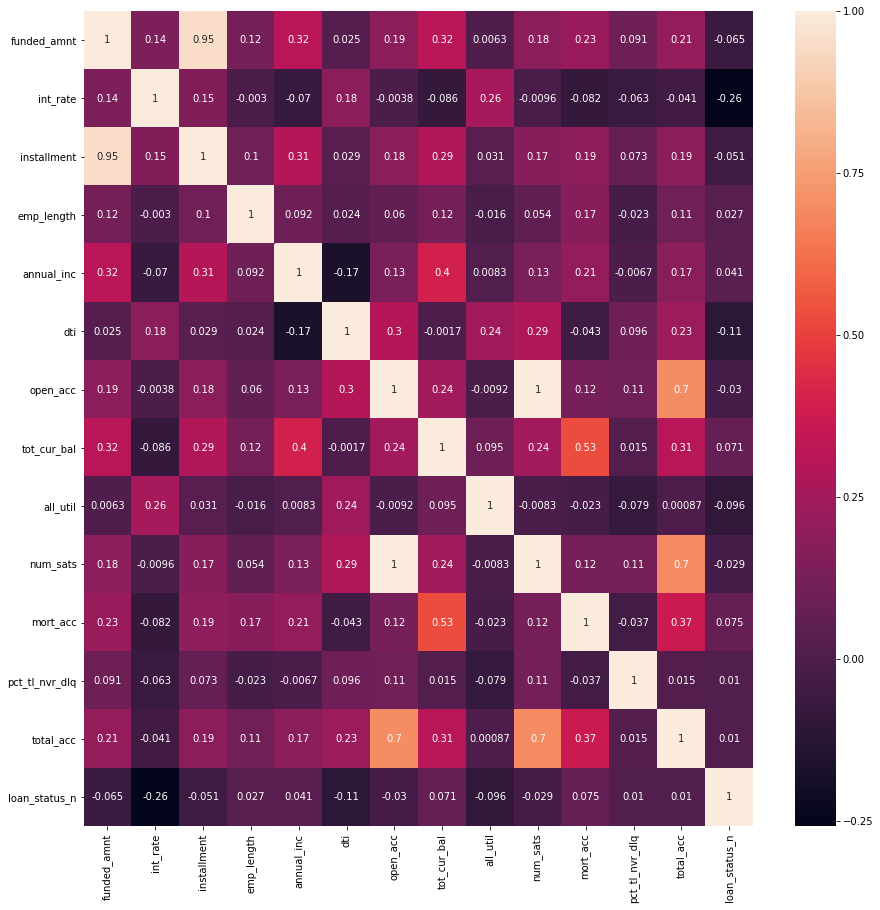

In [22]:
cor = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(cor, annot=True)

## Logistics Model (sub_grades) w/ sample size mitigation

In [23]:
# Set features. This will also be used as your x values.
# x values will be the dscr calculated result, interest rate, amount funded, employment length
selected_features = combined_sample[['sub_grade_A1', 'sub_grade_A2',
       'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
       'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
       'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
       'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
       'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
       'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
       'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
       'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4',
       'sub_grade_G5', 'loan_status_n']]

In [24]:
selected_features['loan_status_n'].value_counts()

0    1026844
1    1026432
Name: loan_status_n, dtype: int64

In [26]:
X = selected_features.drop("loan_status_n", axis=1)
y = selected_features['loan_status_n']

In [27]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(fit_intercept=False)
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=0)

print ("number of training samples: ", len(X_train))
print ("number of test samples: ", len(y_test))

number of training samples:  615982
number of test samples:  1437294


In [29]:
model.fit(X_train,y_train)

C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
print(f"Training Accuracy: {model.score(X_train, y_train)*100}")
print(f"Testing Accuracy: {model.score(X_test, y_test)*100}")

Training Accuracy: 63.81826092320879
Testing Accuracy: 63.81825847738875


In [31]:
y_pred = model.predict(X_test)

In [32]:
results = pd.DataFrame({"Prediction":y_pred, "Actual":y_test}).reset_index(drop=True)
results['match'] = results['Prediction'] == results['Actual']
results.head()


,Prediction,Actual,match
0,1,0,False
1,1,1,True
2,0,0,True
3,0,0,True
4,0,0,True


## Evaluating the Logistics Model

### Null Accuracy

In [33]:
y_test.value_counts()

1    718864
0    718430
Name: loan_status_n, dtype: int64

In [34]:
# calculate null accuracy (for binary classification problem coded as 0/1)
# a dumb that always predicts that a loan is not bad, will be correct 50% of the time.
# vs model accuracy of 55% Random Forrest does NOT look good

max(y_test.mean(), 1 - y_test.mean())

0.5001509781575655

### Confusion Matrix

In [35]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

## Results


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

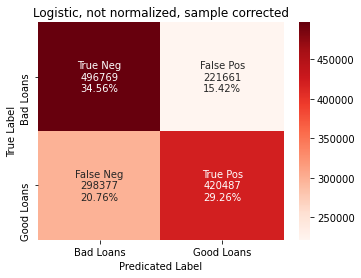

In [36]:
plt.figure()
plot_confusion_matrix(cnf_matrix, title='Logistic, not normalized, sample corrected')

In [37]:
get_confusion_stats(y_test,y_pred)

True Negatives:  496769 34.56279647726909
False Positives:  221661 15.422105706974357
False Negatives:  298377 20.759635815636884
True Positives:  420487 29.25546200011967
Accuracy 63.81825847738876
Precision 0.65
Recall 0.58
F1 Score 0.62
Specificity 0.69


## Kfold Stratified (logistics model, sub_grades)

In [38]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, random_state=42)
skf


StratifiedKFold(n_splits=3, random_state=42, shuffle=False)

In [39]:
X.shape, y.shape

((2053276, 35), (2053276,))

In [40]:
skf.split(X,y)

<generator object _BaseKFold.split at 0x000002059AA8F7C8>

In [41]:
X.iloc[1965]

sub_grade_A1    0
sub_grade_A2    0
sub_grade_A3    0
sub_grade_A4    0
sub_grade_A5    0
               ..
sub_grade_G1    0
sub_grade_G2    0
sub_grade_G3    0
sub_grade_G4    0
sub_grade_G5    0
Name: 92608, Length: 35, dtype: uint8

In [44]:
accuracy = []
skf = StratifiedKFold(n_splits=5, random_state=None)
skf.get_n_splits(X, y)
# X is the featue set and y is the target
for train_index, test_index in skf.split(X, y):
    print("Train", train_index, "Validation:", test_index)
    X1_train, X1_test = X.iloc[train_index], X.iloc[test_index]
    y1_train, y1_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X1_train,y1_train)
    y1_pred = model.predict(X1_test)
    score = accuracy_score(y1_pred, y1_test)
    accuracy.append(score)

print(accuracy)

5

Train [ 205287  205288  205289 ... 2053273 2053274 2053275] Validation: [      0       1       2 ... 1231798 1231799 1231800]


C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Train [      0       1       2 ... 2053273 2053274 2053275] Validation: [ 205287  205288  205289 ... 1437167 1437168 1437169]


C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Train [      0       1       2 ... 2053273 2053274 2053275] Validation: [ 410574  410575  410576 ... 1642536 1642537 1642538]


C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Train [      0       1       2 ... 2053273 2053274 2053275] Validation: [ 615860  615861  615862 ... 1847905 1847906 1847907]


C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Train [      0       1       2 ... 1847905 1847906 1847907] Validation: [ 821146  821147  821148 ... 2053273 2053274 2053275]


C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

[0.6471450557157329, 0.6515331567053689, 0.6289269581522202, 0.6365172711887107, 0.6267904367180156]


In [146]:
np.array(accuracy).mean()

0.6525297346559363

## Confustion Matrix (Kfold Stratified)

In [45]:
cnf_matrix = confusion_matrix(y1_test, y1_pred)#y_pred_tree
np.set_printoptions(precision=2)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

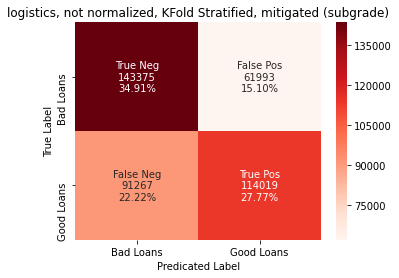

In [46]:
plt.figure()
plot_confusion_matrix(
    cnf_matrix, title='logistics, not normalized, KFold Stratified, mitigated (subgrade)')

## Conclusions and Next Steps
* Precision - Too low for the industry, we have to try to minimize the False Positives.  When a positive is predicated, how often is prediction correct? TP / TP + FP

* Recall (aka sensitivity)- The raw count is good so this should correlate. When athe actual value is positvied, how often is the prediction correct? TP / TP + FN

* Specificity - highlights a weakness for type of industry, too many False Positives (type 1 error), affecting the score Even for P2P type loans. When the actual value is negative, how often is the prediction correct?  tn/(tn+fp)

* A accuracy is .13 better than a coin toss

* Peformed a CrossValidation Kfold Stratified for further evaluation. Average Accuracy with 5 experiments was . 

* Try some different features and models



# Logistics Model (subgrades) w/out sample mitigation

In [51]:
# Set features. This will also be used as your x values.
# x values will be the dscr calculated result, interest rate, amount funded, employment length
selected_features = data[['sub_grade_A1', 'sub_grade_A2',
       'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
       'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
       'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
       'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
       'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
       'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
       'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
       'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4',
       'sub_grade_G5', 'loan_status_n']]

In [52]:
selected_features['loan_status_n'].value_counts()

1    1026432
0     256711
Name: loan_status_n, dtype: int64

In [53]:
X = selected_features.drop("loan_status_n", axis=1)
y = selected_features['loan_status_n']

In [54]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(fit_intercept=False)
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=0)

print ("number of training samples: ", len(X_train))
print ("number of test samples: ", len(y_test))

number of training samples:  384942
number of test samples:  898201


In [56]:
model.fit(X_train,y_train)

C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
print(f"Training Accuracy: {model.score(X_train, y_train)*100}")
print(f"Testing Accuracy: {model.score(X_test, y_test)*100}")

Training Accuracy: 80.00711795543225
Testing Accuracy: 80.00180360520642


In [58]:
y_pred = model.predict(X_test)

In [59]:
results = pd.DataFrame({"Prediction":y_pred, "Actual":y_test}).reset_index(drop=True)
results['match'] = results['Prediction'] == results['Actual']
results.head()


,Prediction,Actual,match
0,1,1,True
1,1,0,False
2,1,1,True
3,1,1,True
4,1,1,True


In [60]:
cnf_matrix = confusion_matrix(y_test, y_pred)#y_pred_tree
np.set_printoptions(precision=2)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

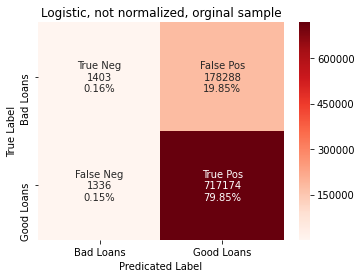

In [62]:
plt.figure()
plot_confusion_matrix(cnf_matrix, title='Logistic, not normalized, orginal sample')

In [63]:
get_confusion_stats(y_test,y_pred)

True Negatives:  1403 0.15620111756722604
False Positives:  178288 19.84945463209237
False Negatives:  1336 0.14874176270122166
True Positives:  717174 79.84560248763918
Accuracy 80.0018036052064
Precision 0.80
Recall 1.00
F1 Score 0.89
Specificity 0.01


# XG Boost (sample mitigated, subgrade)

In [67]:
#conda install -c anaconda py-xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error

In [68]:
# define model
model = XGBClassifier()

In [81]:
# Set features. This will also be used as your x values.
# x values will be the dscr calculated result, interest rate, amount funded, employment length
selected_features = combined_sample[['sub_grade_A1', 'sub_grade_A2',
       'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
       'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
       'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
       'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
       'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
       'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
       'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
       'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4',
       'sub_grade_G5']]

In [82]:
target = combined_sample['loan_status_n']

In [83]:
X,y = selected_features,target

In [84]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [85]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print ("number of training samples: ", len(X_train))
print ("number of test samples: ", len(y_test))

number of training samples:  1642620
number of test samples:  410656


In [86]:
y_test.value_counts()

0    205754
1    204902
Name: loan_status_n, dtype: int64

In [87]:
xg_reg = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10) #scale_pos_weight' = sum_wneg/sum_wpos

In [88]:
xg_reg.fit(X_train,y_train)

y_pred = xg_reg.predict(X_test)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [89]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.607726


## Confusion Matrix

In [90]:
cnf_matrix = confusion_matrix(y_test, y_pred)#y_pred_tree
np.set_printoptions(precision=2)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

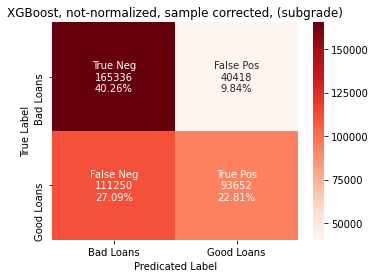

In [91]:
plt.figure()
plot_confusion_matrix(cnf_matrix, title='XGBoost, not-normalized, sample corrected, (subgrade)')

In [92]:
get_confusion_stats(y_test,y_pred)

True Negatives:  165336 40.26143536195745
False Positives:  40418 9.842301098729838
False Negatives:  111250 27.090801059767788
True Positives:  93652 22.805462479544925
Accuracy 63.066897841502374
Precision 0.70
Recall 0.46
F1 Score 0.55
Specificity 0.80


# XG Boost (weighted, dti int_rate,emp_length)

In [151]:
#conda install -c anaconda py-xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error

In [152]:
# define model
model = XGBClassifier()

In [153]:
# Set features. This will also be used as your x values.
# x values will be the dscr calculated result, interest rate, amount funded, employment length
selected_features = data[['dti','int_rate','emp_length']]
# selected_features = data[['sub_grade_A1', 'sub_grade_A2',
#        'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
#        'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
#        'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
#        'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
#        'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
#        'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
#        'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
#        'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4',
#        'sub_grade_G5']]

In [154]:
target = data['loan_status_n']

In [155]:
X,y = selected_features,target

In [156]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [157]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print ("number of training samples: ", len(X_train))
print ("number of test samples: ", len(y_test))

number of training samples:  1026514
number of test samples:  256629


In [158]:
y_test.value_counts()

1    205360
0     51269
Name: loan_status_n, dtype: int64

In [159]:
#set  parameters for XGBClassifer
xg_reg = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10, scale_pos_weight = .29, max_delta_step = 1)

In [160]:
xg_reg.fit(X_train,y_train)

y_pred = xg_reg.predict(X_test)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=1, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.29, seed=None,
              silent=None, subsample=1, verbosity=1)

In [161]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.525751


## Confusion Matrix

In [162]:
cnf_matrix = confusion_matrix(y_test, y_pred)#y_pred_tree
np.set_printoptions(precision=2)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

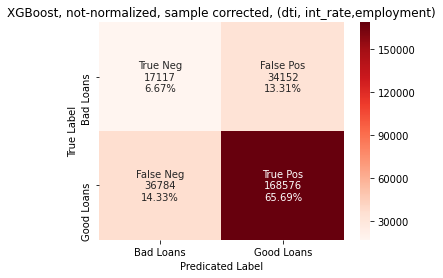

In [163]:
plt.figure()
plot_confusion_matrix(cnf_matrix, title='XGBoost, not-normalized, sample corrected, (dti, int_rate,employment)')

In [164]:
get_confusion_stats(y_test,y_pred)

True Negatives:  17117 6.66993987429324
False Positives:  34152 13.307927007469928
False Negatives:  36784 14.333532063796376
True Positives:  168576 65.68860105444045
Accuracy 72.3585409287337
Precision 0.83
Recall 0.82
F1 Score 0.83
Specificity 0.33


## Kfold Stratified

In [165]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, random_state=42)
skf

StratifiedKFold(n_splits=3, random_state=42, shuffle=False)

In [166]:
X.shape, y.shape

((1283143, 3), (1283143,))

In [167]:
skf.split(X,y)

<generator object _BaseKFold.split at 0x000002059CB9F048>

In [168]:
X.iloc[1965]

dti           25.70
int_rate      15.02
emp_length    10.00
Name: 91919, dtype: float64

In [169]:
accuracy=[]
skf=StratifiedKFold(n_splits=5, random_state=None)
skf.get_n_splits(X,y)
#X is the featue set and y is the target
for train_index, test_index in skf.split(X,y):
    print("Train",train_index,"Validation:", test_index)
    X1_train, X1_test = X.iloc[train_index], X.iloc[test_index]
    y1_train, y1_test = y.iloc[train_index], y.iloc[test_index]
    
    xg_reg.fit(X1_train, y1_train)
    y1_pred = xg_reg.predict(X1_test)
    score=accuracy_score(y1_pred,y1_test)
    accuracy.append(score)
    
print(accuracy)

5

Train [ 221907  221910  221912 ... 1283140 1283141 1283142] Validation: [     0      1      2 ... 265601 265603 265604]


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=1, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.29, seed=None,
              silent=None, subsample=1, verbosity=1)

Train [      0       1       2 ... 1283140 1283141 1283142] Validation: [221907 221910 221912 ... 524424 524425 524426]


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=1, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.29, seed=None,
              silent=None, subsample=1, verbosity=1)

Train [      0       1       2 ... 1283140 1283141 1283142] Validation: [469015 469016 469030 ... 785718 785719 785720]


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=1, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.29, seed=None,
              silent=None, subsample=1, verbosity=1)

Train [      0       1       2 ... 1283140 1283141 1283142] Validation: [ 717202  717206  717221 ... 1032795 1032796 1032797]


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=1, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.29, seed=None,
              silent=None, subsample=1, verbosity=1)

Train [      0       1       2 ... 1032795 1032796 1032797] Validation: [1000300 1000326 1000334 ... 1283140 1283141 1283142]


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=1, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.29, seed=None,
              silent=None, subsample=1, verbosity=1)

[0.7136188286638351, 0.7164077325633502, 0.7122995152516483, 0.7137529809685615, 0.7398530168181181]


In [170]:
rmse = np.sqrt(mean_squared_error(y1_test, y1_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.510046


In [171]:
np.array(accuracy).mean()

0.7191864148531026

## Confusion Matrix

In [173]:
cnf_matrix = confusion_matrix(y1_test, y1_pred)#y_pred_tree
np.set_printoptions(precision=2)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

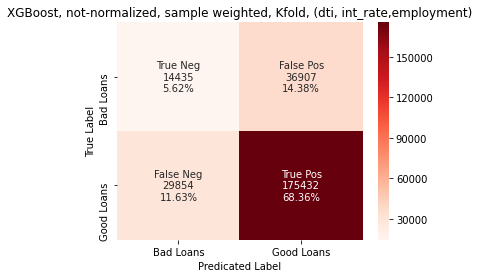

In [176]:
plt.figure()
plot_confusion_matrix(cnf_matrix, title='XGBoost, not-normalized, sample weighted, Kfold, (dti, int_rate,employment)')

In [175]:
get_confusion_stats(y1_test,y1_pred)

True Negatives:  14435 5.6248733575447725
False Positives:  36907 14.381517215580528
False Negatives:  29854 11.633181102607667
True Positives:  175432 68.36042832426703
Accuracy 73.9853016818118
Precision 0.83
Recall 0.85
F1 Score 0.84
Specificity 0.28


## Results
* Most balanced between highest accuracy and best specificity at that accuracy

# XG Boost II (weighted, sub_int)
* going to weight the unbalanced sample and use sub_int instead hot encoded grades

In [120]:
data['loan_status'].value_counts()

Good    1026432
Bad      256711
Name: loan_status, dtype: int64

In [121]:
data.columns

Index(['funded_amnt', 'term', 'int_rate', 'installment', 'grade',
       'application_type', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose',
       'addr_state', 'dti', 'open_acc', 'tot_cur_bal', 'all_util', 'num_sats',
       'mort_acc', 'pct_tl_nvr_dlq', 'total_acc', 'last_pymnt_d',
       'loan_status_n', 'sub_int', 'sub_grade_A1', 'sub_grade_A2',
       'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
       'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
       'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
       'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
       'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
       'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
       'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
       'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4',
       'sub_gr

In [122]:
#conda install -c anaconda py-xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error

In [123]:
# define model
model = XGBClassifier()

In [124]:
selected_features = data[['sub_int']]

In [125]:
target = data['loan_status_n']

In [126]:
X,y = selected_features,target

In [127]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [128]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123)

print("number of training samples: ", len(X_train))
print("number of test samples: ", len(y_test))

number of training samples:  1026514
number of test samples:  256629


In [131]:
y_test.value_counts()

1    205360
0     51269
Name: loan_status_n, dtype: int64

In [130]:
# set  parameters for XGBClassifer
xg_reg = xgb.XGBClassifier(objective='reg:logistic', colsample_bytree=0.3, learning_rate=0.1,
                           max_depth=5, alpha=10, n_estimators=10, scale_pos_weight=.29, max_delta_step=1)

In [132]:
xg_reg.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=1, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.29, seed=None,
              silent=None, subsample=1, verbosity=1)

In [133]:
y_pred = xg_reg.predict(X_test)

In [134]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.599706


##Confustion Matrix

In [135]:
cnf_matrix = confusion_matrix(y_test, y_pred)  # y_pred_tree
np.set_printoptions(precision=2)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

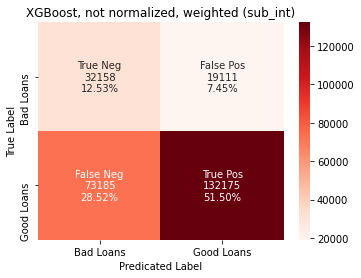

In [136]:
plt.figure()
plot_confusion_matrix(cnf_matrix, title='XGBoost, not normalized, weighted (sub_int)')

In [138]:
get_confusion_stats(y_test,y_pred)

True Negatives:  32158 12.530929863733247
False Positives:  19111 7.446937018029918
False Negatives:  73185 28.51782144652397
True Positives:  132175 51.50431167171286
Accuracy 64.0352415354461
Precision 0.87
Recall 0.64
F1 Score 0.74
Specificity 0.63


## Kfold Stratified

In [139]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, random_state=42)
skf

StratifiedKFold(n_splits=3, random_state=42, shuffle=False)

In [140]:
X.shape, y.shape

((1283143, 1), (1283143,))

In [141]:
skf.split(X,y)

<generator object _BaseKFold.split at 0x000002059CACF1C8>

In [142]:
X.iloc[1965]

sub_int    13.0
Name: 91919, dtype: float64

In [143]:
accuracy=[]
skf=StratifiedKFold(n_splits=5, random_state=None)
skf.get_n_splits(X,y)
#X is the featue set and y is the target
for train_index, test_index in skf.split(X,y):
    print("Train",train_index,"Validation:", test_index)
    X1_train, X1_test = X.iloc[train_index], X.iloc[test_index]
    y1_train, y1_test = y.iloc[train_index], y.iloc[test_index]
    
    xg_reg.fit(X1_train, y1_train)
    y1_pred = xg_reg.predict(X1_test)
    score=accuracy_score(y1_pred,y1_test)
    accuracy.append(score)
    
print(accuracy)

5

Train [ 221907  221910  221912 ... 1283140 1283141 1283142] Validation: [     0      1      2 ... 265601 265603 265604]


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=1, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.29, seed=None,
              silent=None, subsample=1, verbosity=1)

Train [      0       1       2 ... 1283140 1283141 1283142] Validation: [221907 221910 221912 ... 524424 524425 524426]


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=1, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.29, seed=None,
              silent=None, subsample=1, verbosity=1)

Train [      0       1       2 ... 1283140 1283141 1283142] Validation: [469015 469016 469030 ... 785718 785719 785720]


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=1, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.29, seed=None,
              silent=None, subsample=1, verbosity=1)

Train [      0       1       2 ... 1283140 1283141 1283142] Validation: [ 717202  717206  717221 ... 1032795 1032796 1032797]


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=1, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.29, seed=None,
              silent=None, subsample=1, verbosity=1)

Train [      0       1       2 ... 1032795 1032796 1032797] Validation: [1000300 1000326 1000334 ... 1283140 1283141 1283142]


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=1, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.29, seed=None,
              silent=None, subsample=1, verbosity=1)

[0.6534777695514944, 0.6893180427777064, 0.6366140873170504, 0.6619971320354755, 0.621241641597955]


In [144]:
rmse = np.sqrt(mean_squared_error(y1_test, y1_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.615433


In [145]:
np.array(accuracy).mean()

0.6525297346559363

## Confustion Matrix (Kfold Stratified)

In [147]:
cnf_matrix = confusion_matrix(y1_test, y1_pred)#y_pred_tree
np.set_printoptions(precision=2)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

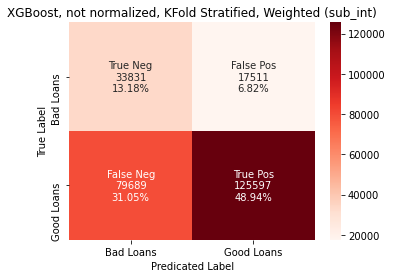

In [148]:
plt.figure()
plot_confusion_matrix(
    cnf_matrix, title='XGBoost, not normalized, KFold Stratified, Weighted (sub_int)')

In [150]:
get_confusion_stats(y1_test,y1_pred)

True Negatives:  33831 13.1828950854934
False Positives:  17511 6.823495487631903
False Negatives:  79689 31.052340352572593
True Positives:  125597 48.9412690743021
Accuracy 62.1241641597955
Precision 0.88
Recall 0.61
F1 Score 0.72
Specificity 0.66


## Results
* Most conservative results with respect to minimizing False Positives and as much accuracy 